

# Netflix Challenge

## Netflix Rating Prediction with Spark

<br>

### Netflix Challenge Tutorial

In this tutorial, you'll build a movie rating prediction system using Apache Spark and the [Netflix Prize dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data).

You'll learn how to:

* Explore and process 100M+ ratings using Spark
* Engineer features like rating date and release year difference
* Train and tune models (Linear Regression, Decision Trees, GBT)
* Evaluate performance with RMSE
* Analyze feature importance for better model understanding

We’ll take you from raw Parquet files to model evaluation in a streamlined, scalable workflow.

[Start with Feature Engineering](#FE) | [Jump to Modeling](#ml-modelling) | [Read the Conclusions](#conclusions)

### Data

The Netflix Prize dataset contains over **100 million movie ratings** from anonymous users. The data has been preprocessed into Parquet format for efficient distributed handling.

Each row contains the following columns:

| Column          | Type    | Description                       |
| --------------- | ------- | --------------------------------- |
| `CustomerID`    | Integer | Anonymized user identifier        |
| `MovieID`       | Integer | Unique identifier for each movie  |
| `Rating`        | Integer | Rating given by the user (1 to 5) |
| `RatingDate`    | Date    | Date the rating was submitted     |
| `YearOfRelease` | Integer | Year the movie was released       |

#### Feature Engineering

To improve model performance, we generate new features:

| New Column           | Description                                                             |
| -------------------- | ----------------------------------------------------------------------- |
| `RatingYear`         | Year extracted from `RatingDate`                                        |
| `RatingMonth`        | Month extracted from `RatingDate`                                       |
| `Diff_RatingRelease` | Approximate number of years between rating and movie release            |
| `Diff_binned`        | Binned version of `Diff_RatingRelease` into categories like 1–4, 5–9... |
| `HashedMovieID`      | Hashed representation of `MovieID` for scalable ML input                |
| `HashedCustomerID`   | Hashed representation of `CustomerID`                                   |

These features help us capture **temporal patterns**, **movie popularity**, and **user behavior**—key components in a real-world recommender system.


## Dependencies

In [1]:
# %pip install kagglehub pyspark==4.0.0 seaborn matplotlib pandas numpy

In [25]:
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import date_format, datediff, to_date, udf, count, countDistinct
from pyspark.sql.functions import round as spark_round
from pyspark.ml.feature import FeatureHasher, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml import Pipeline

In [26]:
DATA_DIR = "../datasets/netflix-challenge"

<a name="initial_eda"></a>


## [Initial Exploratory Data Analysis](#top)

Now when the data has gone through some initial preparation and convertion we can take a closer look at it. Start by initiating a SparkContext and SparkSession. To deal with potential memory issues during later model training on the full dataset, the following settings will help mitigate those. 

### Memory and Garbage Collection

| Setting                                                                                        | Description                                                  |
| ---------------------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| `spark.driver.memory = 15g`                                                                    | Allocates 15 GB RAM to the Spark driver.                     |
| `spark.executor.JavaOptions = -XX:+UseG1GC`                                                    | Enables G1 Garbage Collector for executors.                  |
| `spark.executor.extraJavaOptions = -XX:ConcGCThreads=20 -XX:InitiatingHeapOccupancyPercent=35` | Tunes GC thread count and early collection threshold.        |

### Execution Behavior

| Setting                                            | Description                                        |
| -------------------------------------------------- | -------------------------------------------------- |
| `spark.sql.autoBroadcastJoinThreshold = -1`        | Disables automatic broadcast joins.                |
| `spark.sql.execution.arrow.pyspark.enabled = true` | Enables Arrow for faster JVM↔Python data transfer. |


<a name="data_path"></a>


In [27]:
# Initiate SparkContext and SparkSession
try:
    conf = (
        SparkConf()
        .setMaster("local[*]")
        # JVM tuning
        .set("spark.executor.JavaOptions", "-XX:+UseG1GC")
        .set(
            "spark.executor.extraJavaOptions",
            "-XX:ConcGCThreads=20 -XX:InitiatingHeapOcuupancyPercent=35",
        )
        # Driver & shuffle
        .set("spark.driver.memory", "15g")
        .set("spark.sql.autoBroadcastJoinThreshold", "-1")   #-1 ⇒ disable broadcast
        # Arrow
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
    )

    spark = (
        SparkSession.builder
        .config(conf=conf)
        .getOrCreate()
    )

    # Keep the console quiet
    spark.sparkContext.setLogLevel("ERROR")
except:
    print("SparkContext already running?")

In [28]:
# Specify data path
data_path = f"{DATA_DIR}/data-parquet/part-00000-*.parquet"

# Load and display the first five rows of the data
df = spark.read.parquet(data_path)
df.show(5)

+-------+----------+------+----------+-------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|
+-------+----------+------+----------+-------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|
|  11745|   1336618|   4.0|2005-08-23|         2005|
|   9458|    289514|   5.0|2005-11-29|         2005|
|   4393|   1930649|   4.0|2004-04-05|         1994|
|   7163|   2511589|   4.0|2000-11-24|         1998|
+-------+----------+------+----------+-------------+
only showing top 5 rows


In [29]:
# Get the unique number of customers
df.select(countDistinct('CustomerID')).show()

+--------------------------+
|count(DISTINCT CustomerID)|
+--------------------------+
|                    376453|
+--------------------------+



In [30]:
# Get the unique number of movies
df.select(countDistinct('MovieID')).show()

+-----------------------+
|count(DISTINCT MovieID)|
+-----------------------+
|                  17498|
+-----------------------+



In [31]:
# Verify that the data types are as expected
df.printSchema()

root
 |-- MovieID: integer (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Rating: float (nullable = true)
 |-- RatingDate: date (nullable = true)
 |-- YearOfRelease: integer (nullable = true)



In [32]:
# Display a summary over the dataset
df.summary().show(truncate=False)

+-------+-----------------+-----------------+------------------+------------------+
|summary|MovieID          |CustomerID       |Rating            |YearOfRelease     |
+-------+-----------------+-----------------+------------------+------------------+
|count  |2469758          |2469758          |2469758           |2469729           |
|mean   |9072.693858669554|1323466.822818673|3.6039093708776324|1993.9069978932912|
|stddev |5130.903339351398|764261.4968954367|1.0850219146414768|12.40376553232374 |
|min    |1                |6                |1.0               |1896              |
|25%    |4679             |662953           |3.0               |1990              |
|50%    |9051             |1320864          |4.0               |1998              |
|75%    |13636            |1984517          |4.0               |2002              |
|max    |17770            |2649429          |5.0               |2005              |
+-------+-----------------+-----------------+------------------+------------

We can verify that we have around 100 million ratings in the range [1-5] and that each column has the expected data type. The following can also be noted:

- There are 17770 unique movies
- Over 2.6 million unique customers
- The oldest movie was released in 1896, while the most recent in 2005
- There are some missing values in the `YearOfRelease` column


While we will do a more thorough visulisation of the dataset efter engineering more features, we can already now remove missing values. 

In [33]:
# Drop rows with NULL values
df = df.dropna(how="any")

In [34]:
# filter on NULL values to confirm there are no left
df.filter(" is NULL OR ".join(df.columns) + " is NULL").show()

+-------+----------+------+----------+-------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|
+-------+----------+------+----------+-------------+
+-------+----------+------+----------+-------------+



It's confirmed - there are no `NULL` values left.


<br>

<a name="FE"></a>


## [Feature Engineering](#top)

We will do some simple feature engineering by extracting year and month from the `RatingDate` column as well as calculating the difference in years between that column and the `YearOfRelease` column. Perhaps knowing when the rating was given and its relation to the release date might better help us determine what rating was given by a specific user. We should also make sure to convert the columns to adequate data types using the `.cast()` method. 

Engineering the difference, `Diff_RatingRelease`, is the trickiest and needs some extra work. 

In [35]:
# Create new columns RatingYear, RatingMonth and Diff_RatingRelease
df = df.withColumn("RatingYear", date_format(df.RatingDate, "yyyy").cast(IntegerType())) \
       .withColumn("RatingMonth", date_format(df.RatingDate, "M").cast(IntegerType())) \
       .withColumn("Diff_RatingRelease", 
                   spark_round(datediff(df.RatingDate, 
                            to_date(df.YearOfRelease.cast("string"), 
                                    "yyyy"))/365.25, 0)
                  )

df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|
|   7163|   2511589|   4.0|2000-11-24|         1998|      2000|         11|               3.0|
+-------+----------+------+----------+-------------+----------+-----------+------------------+
only showing top 5 rows


Furthermore, we can also bin the `Diff_ReleaseRating` column into `Diff_binned` to have fewer categories to deal with. I'm creating these bins rather arbitrary for now. Ideally however, we would bin in several different ways before training and evaluating these models to find the most suited bins for the problem. I will take a shortcut and bin in the following way though:

 
| Values        | Bin                |
|---------------|--------------------|
| Negative      | -1                 |
| 1 - 4.99      | 1, 2, 3, 4 and 5, respectively |
| 5 - 9.99      | 5                  |
| 10 - 49.99    | 10                 |
| 50 and above  | 50                 |

<br>

The process for that is displayed below, with the function `bin_diff` deciding what thresholds to bin on. 

In [36]:
@udf(returnType=IntegerType(), useArrow=True)
def bin_diff(x):
    """ Function for binning a value x. """
    if x is not None:
        if x < 0:
            return -1
        if x < 5:
            return x
        elif x < 10:
            return 5
        elif x < 50:
            return 10
        else:
            return 50
    else:
        return 0

In [37]:
# Bin the Diff_RatingRelease column
df = df.withColumn("Diff_binned", bin_diff("Diff_RatingRelease").cast(IntegerType()))
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|         10|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|          1|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|          1|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|         10|
|   7163|   2511589|   4.0|2000-11-24|         1998|      2000|         11|               3.0|          3|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+
only showing top 5 rows


Moreover, we have some categorical variables that should be treated before moving forward. These are the nominal variables `MovieID` and `CustomerID`. Under current rank order representation, the `CustomerID` column will teach the estimator that, for example, the customer with `CustomerID` *1488844* is larger/bigger/worth more than the customer with `CustomerID` *822109*. Such bias is misleading and we need to address that. There are several options we can take here, such as one-hot encoding and bin-counting, but we will go with hashing as it's more straight forward and offers computational advantages. Spark's `FeatureHasher` is well suited for this.  

We leave the ordinal variables `YearOfRelease`, `RatingYear` and `RatingsMonth` as is since they are sensitive to rank order. 

In [38]:
# Create two hashers to keep the columns apart
hasherM = FeatureHasher().setInputCols(["MovieID"]) \
                        .setOutputCol("HashedMovieID")
hasherC = FeatureHasher().setInputCols(["CustomerID"]) \
                        .setOutputCol("HashedCustomerID")

# Apply the hashers on the dataset and display the resulting DataFrame
df = hasherM.transform(df)
df = hasherC.transform(df)
df.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|   6287|   2180413|   5.0|2005-08-26|         1990|      2005|          8|              16.0|         10|(262144,[138338],...|(262144,[211647],...|
|  11745|   1336618|   4.0|2005-08-23|         2005|      2005|          8|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|   9458|    289514|   5.0|2005-11-29|         2005|      2005|         11|               1.0|          1|(262144,[138338],...|(262144,[211647],...|
|   4393|   1930649|   4.0|2004-04-05|         1994|      2004|          4|              10.0|         10|

Let's keep the target variable `Rating` as a float. This allow us to approach it as a regression rather than as a classification problem, with the advantage of providing us with the size of the error on each prediction. Besides, that was the approach in the competition.

<a name="data_vis"></a>


## [Data Visualisation](#top)


Plot the count for each of the columns to get a fair estimate of their distribution. The `MovieID` and `CustomerID` columns are truncated due to their large size and only display the lowest five (which each has `count=1`) and highest 100 counts. We also sort these columns on their counts to facilitate interpretation. No need to display the hashed columns as they are hard to interpret for the human eye anyway. 

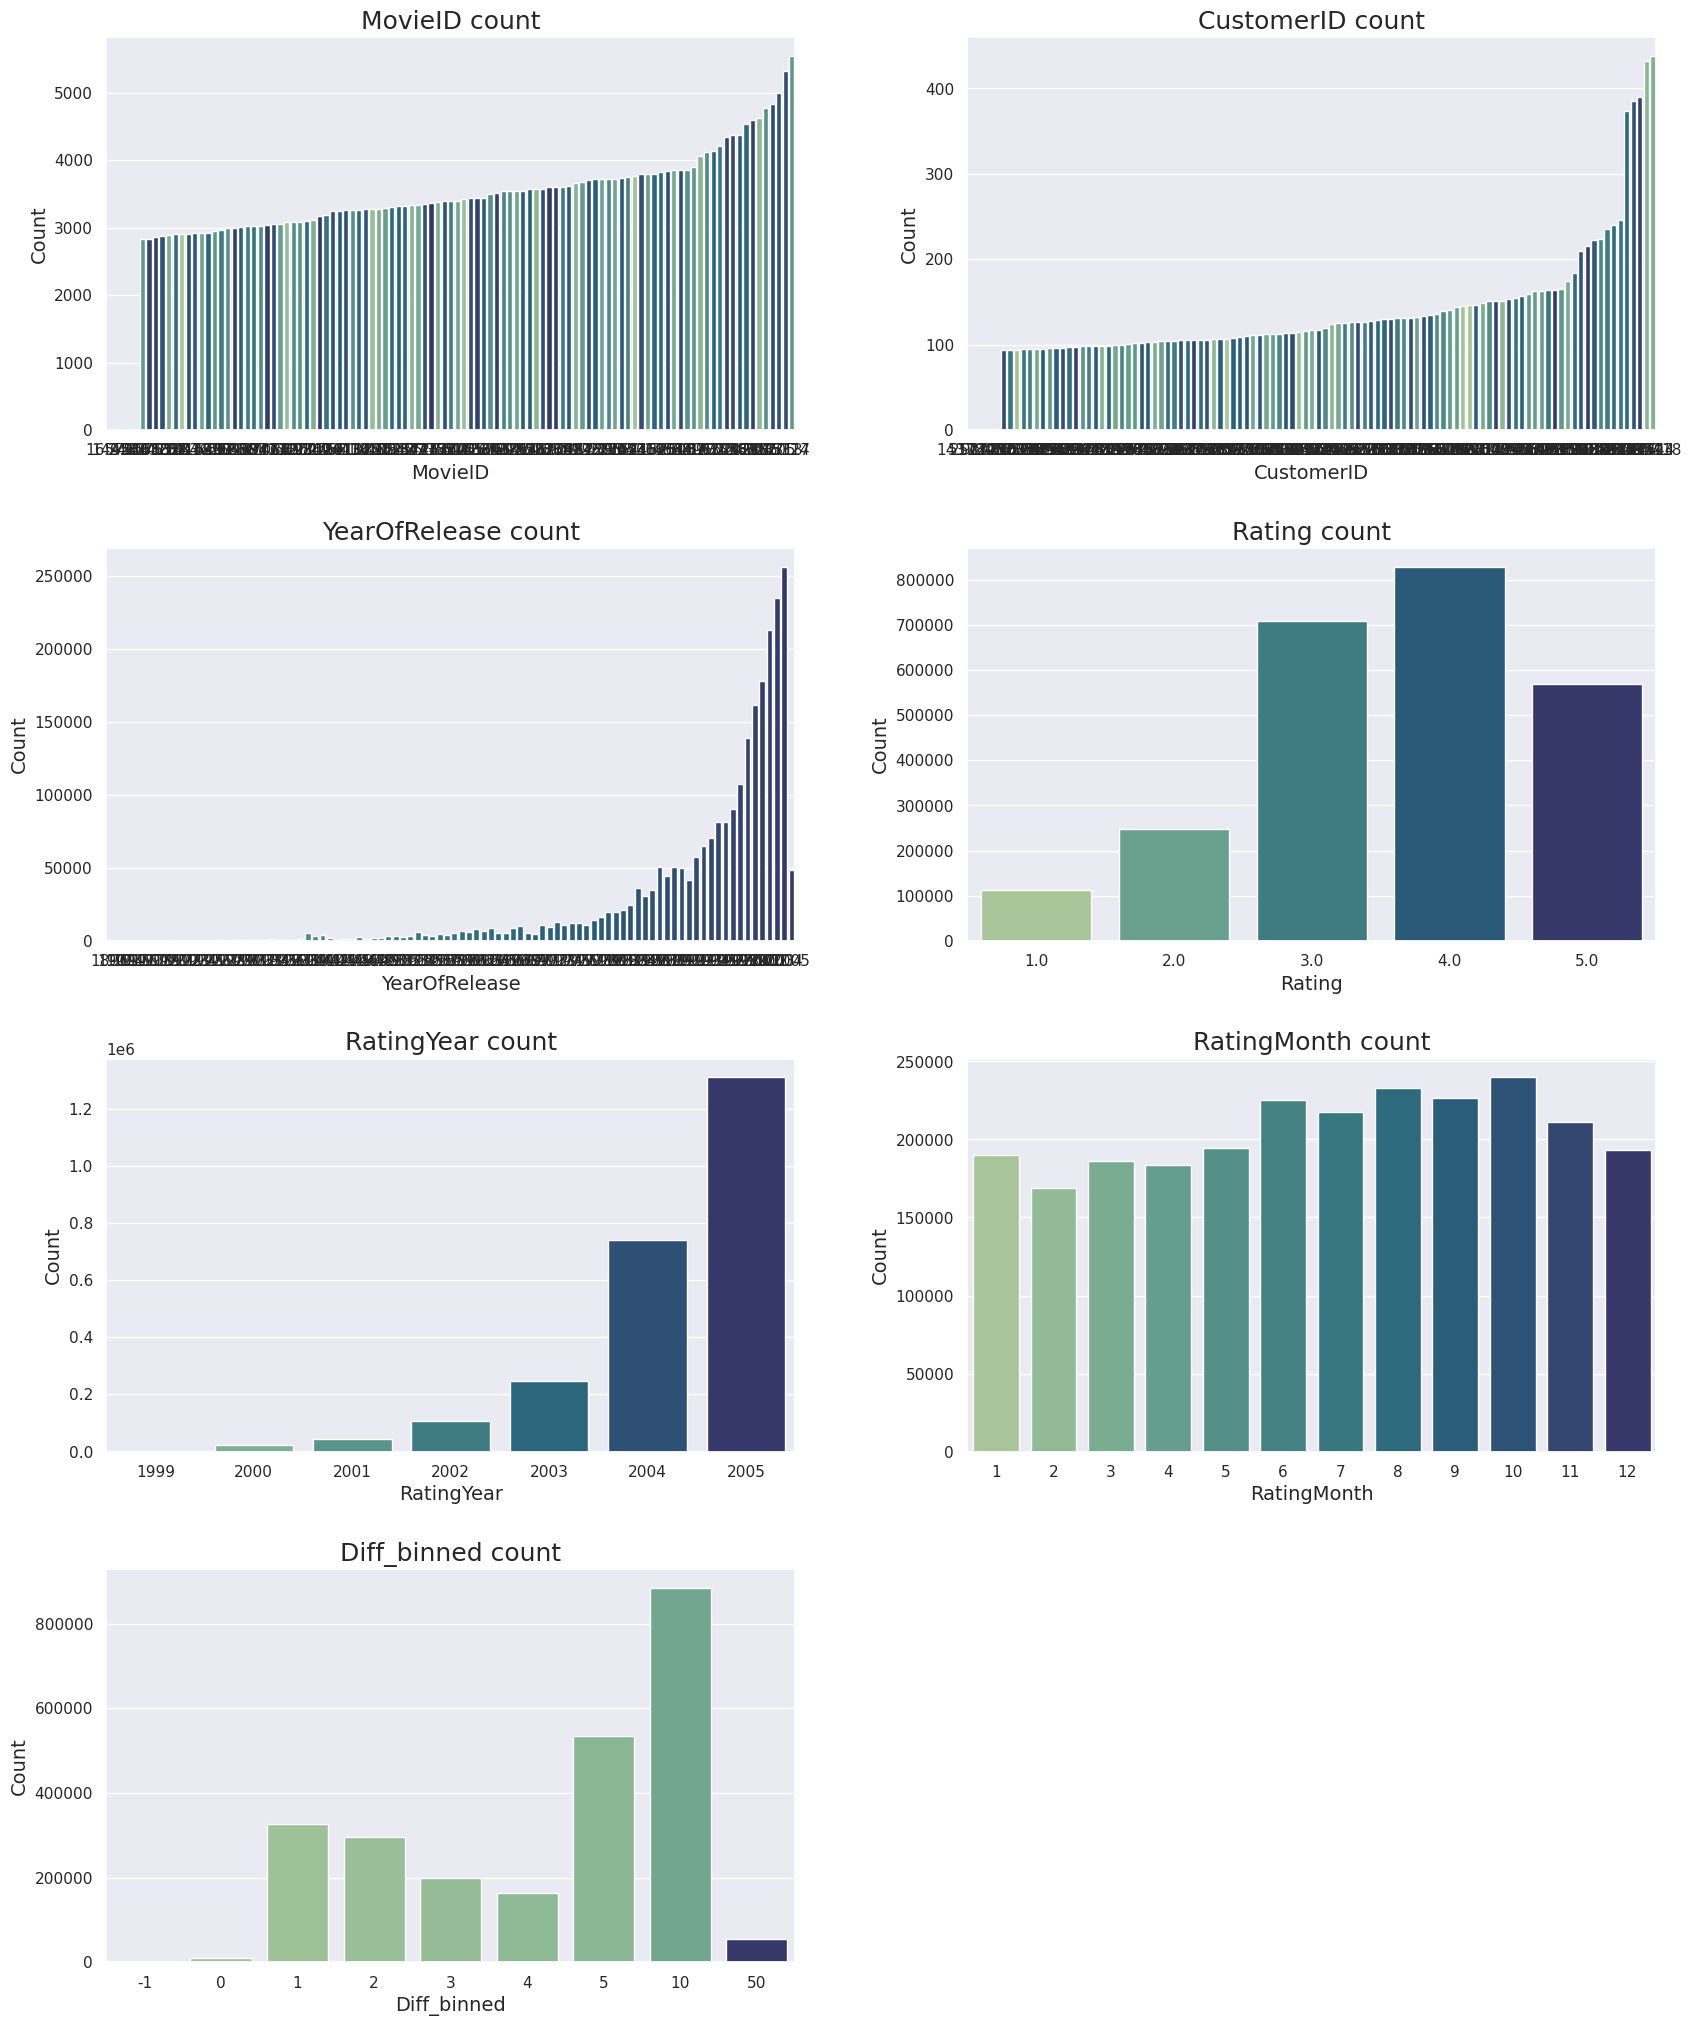

In [39]:
# Select columns to plot
cols_for_display = ["MovieID", 
                    "CustomerID", 
                    "YearOfRelease", 
                    "Rating", 
                    "RatingYear", 
                    "RatingMonth", 
                    "Diff_binned"
                   ]

plt.figure(figsize=(20, 25))
for i, col in enumerate(cols_for_display, 1):
    plt.subplot(4, 2, i)
    
    # Due to their large counts, prepare the ID columns different
    if col in ["CustomerID", "MovieID"]:
        counts = df.groupBy(col).count().orderBy("count").toPandas()
        cc = pd.concat([counts.head(), counts.tail(100)], ignore_index=True)
        
        sns.barplot(x=col, 
                    y="count", 
                    data=cc, 
                    order=cc.sort_values("count")[str(col)],
                    palette="crest",
                    hue=col,
                    legend=False)
    else:
        sns.barplot(x=col, 
                y="count", 
                data=df.groupBy(col).count().toPandas(),
                palette="crest",
                hue=col,
                legend=False)
      
    # Specify labels, title and their size
    plt.xlabel(col, size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{col} count", size=18)
    
plt.subplots_adjust(hspace=0.3, wspace=0.25)

Among other things, we learn the following from above plot:

- `MovieID` and `CustomerID` counts are highly skewed with some movies receiving many reviews and some customers giving many reviews. 
- Most movies are released recently. 
- Most movies have received a *3* or *4* in rating, but there are also many *5*s. *1*s are the rarest.
- Most movies were rated in 2004 and 2005, with over 50% of the ratings in 2005. 
- August, September and October are the most popular months to rate a moive. February the least. 
- Few movies are rated close to their release date (`Diff_binned` = 0). A lot of movies are rated the year after their release or within five years thereafter. *The interpretation of this last plot depends of course a lot on how we binned the column before. And as previously stated, binning is something that should be experimented with for best result.* 

<a name="ml-modelling"></a>

## [Machine Learning modelling](#top)


With a smaller dataset we would prefer to train and test many models using cross-validation. However, with over 100 million ratings, we can consider the data to be fairly large and will thus go with a more traditional train / test split. 80% of the data will be dedicated for training the model while 20% for testing it. Providing a `seed` will allow us to replicate the results.

In [40]:
# Split into train and test sets
splits = df.randomSplit([0.8, 0.2], seed=747)
df_train = splits[0]
df_test = splits[1]

df_train = df_train.persist()
df_test = df_test.persist()

In [41]:
# Display the first five rows on the train set
df_train.show(5)

+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|MovieID|CustomerID|Rating|RatingDate|YearOfRelease|RatingYear|RatingMonth|Diff_RatingRelease|Diff_binned|       HashedMovieID|    HashedCustomerID|
+-------+----------+------+----------+-------------+----------+-----------+------------------+-----------+--------------------+--------------------+
|      1|    379184|   4.0|2005-02-11|         2003|      2005|          2|               2.0|          2|(262144,[138338],...|(262144,[211647],...|
|      1|    729846|   4.0|2005-08-09|         2003|      2005|          8|               3.0|          3|(262144,[138338],...|(262144,[211647],...|
|      1|    767518|   5.0|2005-08-02|         2003|      2005|          8|               3.0|          3|(262144,[138338],...|(262144,[211647],...|
|      1|   1248029|   3.0|2004-04-22|         2003|      2004|          4|               1.0|          1|

Specify target variable and features for modelling. Root Mean Squared Error (RMSE) will be used for evaluating the performance of the model. 

In [42]:
# Specify target variable
target = StringIndexer(inputCol="Rating", 
                       outputCol="label")

# Specify features
input_cols = ["YearOfRelease", 
              "MovieID", 
              "CustomerID",
              "RatingYear", 
              "RatingMonth", 
              "Diff_binned"]
featureAssembler = VectorAssembler(inputCols=input_cols, 
                                   outputCol="features")

# Specify evaluator with the default RMSE as metric
evaluator = RegressionEvaluator(metricName="rmse", 
                                predictionCol="prediction", 
                                labelCol="label")

<a name="baseline"></a>


### [Get baseline results with Linear Regression](#top)

To have something to compare with, we will train and evaluate one of the more simplistic algorithms on the data; Linear Regression, using its default parameters. 

Note that we do this on a smaller fraction of the data to speed things up (file `part-00000-*.parquet`, which is around 2.5 million reviews). You can load it by changing the `data_path` [above](#data_path). 

```python
# Specify data path
data_path = "data-parquet/part-00000-*.parquet"
```

In [43]:
%%time

# Instantiate a Linear regression model with default parameters
lr = LinearRegression()

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, lr])

# Train the model
baseline = pipeline.fit(df_train)

CPU times: user 12.9 ms, sys: 3.62 ms, total: 16.6 ms
Wall time: 7.39 s


On the subset dataset `part-00000`, the training took 7.5s on a Midway Caslake partition compute node with 8 cores and 64G memory.

In [44]:
def evaluate_model(model, trainSet, testSet):
    """ Function for evaluating a model on a train and test set"""
    
    # Evaluate model on train set
    pred_train = model.transform(trainSet)
    rmse_train = evaluator.evaluate(pred_train, {evaluator.metricName: "rmse"})

    # Evaluate model on test set
    pred_test = model.transform(testSet)
    rmse_test = evaluator.evaluate(pred_test, {evaluator.metricName: "rmse"})
    
    # Display results
    time.sleep(1)
    print(f"RMSE train set: {rmse_train:.5f}")
    print(f"RMSE test set:  {rmse_test:.5f}")
    
    return rmse_train, rmse_test

In [45]:
# Evaluate baseline model
rmse_train, rmse_test = evaluate_model(baseline, df_train, df_test)

RMSE train set: 1.15056
RMSE test set:  1.15325


A baseline of RMSE 1.153 is achieved on the test set. The RMSE on the training set is 1.151. There's little difference between the train and test sets, which means variance is low. 

> After evaluating a model using the original `CustomerID` and `MovieID` features instead of the hashed alternatives, `HashedCustomerID` and `HashedMovieID`, I found practically no differences between the two. I will thus go with the original features, and you will simply have to take my words for it. :)


<a name="regressors"></a>


### [Tune and Evaluate Multiple Regressors](#top)


In order to find the best model for the problem, we will evaluate several standard algorithms. Train, tune and evaluate Decision Trees, Random Forest, Gradient-Boosted Trees and Linear Regressors on the dataset. 

[`TrainValidationSplit`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html) randomly splits the input dataset into train and validation sets, and uses evaluation metric on the validation set to select the best model. Similar to CrossValidator, but only splits the set once.

In [25]:
%%time

# Specify regressors to evaluate
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GBTRegressor()
lr = LinearRegression()

regressors = [{"regressor": dt,
               "paramGrid": ParamGridBuilder().addGrid(dt.maxBins, [16, 32]) \
                                              .addGrid(dt.maxDepth, [3, 5, 7]) \
                                              .build()},
              {"regressor": rf,
               "paramGrid": ParamGridBuilder().addGrid(rf.numTrees, [20, 40, 60]) \
                                              .addGrid(rf.maxDepth, [3, 5]) \
                                              .build()},
              {"regressor": gb,
               "paramGrid": ParamGridBuilder().addGrid(gb.subsamplingRate, [1.0, 0.7]) \
                                              .addGrid(gb.maxDepth, [3, 5]) \
                                              .build()},
              {"regressor": lr,
               "paramGrid": ParamGridBuilder().addGrid(lr.maxIter, [100, 1000]) \
                                              .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
                                              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
                                              .build()}
             ]

results = {}
for regressor in regressors:
    name = str(regressor["regressor"]).split("_")[0]
    print(f"\nTuning {name}")
    
    # Create Pipeline
    pipeline = Pipeline(stages=[target, featureAssembler, regressor["regressor"]])
    
    # Specify model training specs
    tvs = TrainValidationSplit(estimator=pipeline, 
                               estimatorParamMaps=regressor["paramGrid"], 
                               evaluator=evaluator,
                               trainRatio=0.75,
                               parallelism=8, 
                               seed=72)
    
    # Train model
    model = tvs.fit(df_train)
    
    # Evaluate model
    rmse_train, rmse_test = evaluate_model(model, df_train, df_test)
    
    # Store the results
    results[name] = {"model": model,
                     "rmse_train": rmse_train,
                     "rmse_test": rmse_test}


Tuning DecisionTreeRegressor


RMSE train set: 1.14888
RMSE test set:  1.15188

Tuning RandomForestRegressor


RMSE train set: 1.14961
RMSE test set:  1.15240

Tuning GBTRegressor


RMSE train set: 1.14813
RMSE test set:  1.15108

Tuning LinearRegression


RMSE train set: 1.15056
RMSE test set:  1.15325
CPU times: user 1.72 s, sys: 572 ms, total: 2.29 s
Wall time: 5min 59s


Although with a very small margin, the Gradient-Boosted Tree Regressor (GBTRegressor) is the most performant model on the test data. Let's extract the best parameters and train it on the entire dataset. 

In [27]:
# Get the best GBTR parameters
best_gbtr = results["GBTRegressor"]["model"].bestModel
maxDepth = best_gbtr.stages[-1]._java_obj.getMaxDepth()
subSamplingsRate = best_gbtr.stages[-1]._java_obj.getSubsamplingRate()

print("maxDepth:        ", maxDepth)
print("subSamplingsRate:", subSamplingsRate)

maxDepth:         5
subSamplingsRate: 0.7



<a name="best_model"></a>


## [Train the Best GBTRegressor on the Full Dataset](#top)


Train the GBTRegressor on the entire dataset using the best parameters.


```python
# Specify data path
data_path = "data-parquet"
```

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import FeatureHasher


@F.udf(returnType=IntegerType())
def bin_diff(x):
    """
    Bin the difference in years between rating and release.
    """
    if x is None:
        return 0
    if x < 0:
        return -1
    if x < 5:
        return int(x)
    if x < 10:
        return 5
    if x < 50:
        return 10
    return 50


def engineer_features(df):
    """
    Extract year/month from RatingDate, compute Diff_RatingRelease, and bin it.
    """
    # Convert YearOfRelease to date (Jan 1 of that year)
    release_date = F.to_date(F.col("YearOfRelease").cast("string"), "yyyy")

    df = (
        df
        .withColumn("RatingYear", F.date_format(F.col("RatingDate"), "yyyy").cast(IntegerType()))
        .withColumn("RatingMonth", F.date_format(F.col("RatingDate"), "M").cast(IntegerType()))
        .withColumn(
            "Diff_RatingRelease",
            F.round(
                F.datediff(F.col("RatingDate"), release_date) / 365.25,
                0
            ).cast(IntegerType())
        )
        .withColumn("Diff_binned", bin_diff(F.col("Diff_RatingRelease")))
    )
    return df


def hash_features(df, num_features=1024):
    """
    Apply FeatureHasher to movie and customer IDs.
    """
    hasher_movie = FeatureHasher(inputCols=["MovieID"], outputCol="HashedMovieID", numFeatures=num_features)
    hasher_cust = FeatureHasher(inputCols=["CustomerID"], outputCol="HashedCustomerID", numFeatures=num_features)

    df = hasher_movie.transform(df)
    df = hasher_cust.transform(df)
    return df

# Load entire dataset
data_path = f"{DATA_DIR}/data-parquet"
df = spark.read.parquet(data_path)
df = df.dropna(how="any")
df = engineer_features(df)
df = hash_features(df)

# Cast Rating to float for regression tasks
df = df.withColumn("Rating", F.col("Rating").cast("float"))

In [39]:
# Split into train and test sets
splits = df.randomSplit([0.8, 0.2], seed=747)
df_train = splits[0]
df_test = splits[1]

df_train = df_train.persist()
df_test = df_test.persist()

In [ ]:
%%time

# Specify model parameters from previous step
gb_best = GBTRegressor(maxDepth=5,
                       subsamplingRate=0.7)

# Put everything in a Pipeline
pipeline = Pipeline(stages=[target, featureAssembler, gb_best])

# Train model
final_model = pipeline.fit(df_train)

In [18]:
# Evaluate the model
best_rmse_train_, best_rmse_test = evaluate_model(final_model, df_train, df_test)

RMSE train set: 1.14898
RMSE test set:  1.14893


We have a final score of 1.149 on the test set. It's barely better than the 1.152 baseline though, and significantly worse than the 0.8572 the team who won the challenge in 2009 got. 

Let's further explore which of the features are most important for the model to make its predicitons. 

<a name="feature_importance"></a>


## [Which Features are most Important?](#top)

The most important features are `YearOfRelease`, `MovieID` and `RatingMonth`, contributing 37, 27 and 20%, respectively, as displayed in the plot below. The difference between the release and rating year, `Diff_binned` contributes a meek 3% to the overall, while `CustomerID` less than 1 percent. 

This means that it matters little *who* rated the movie and far more *which* movie it is. This is reasonable as one would expect that most people would rate a good movie as good and a bad one as bad. 

However, that the release year matters this much is quite surprising. We would need to dig deeper into the data to find out why this may be the case. We won't do that here, but can speculate that, perhaps, older movies are held to newer standards, and since all ratings are from 1999 and later, while some movies are 100 years older than that, their ratings might be biased by this. Who hasn't re-watched a favourite movie from childhood and found it awful at later years? Or perhaps, newer movies might simply be better than older? 

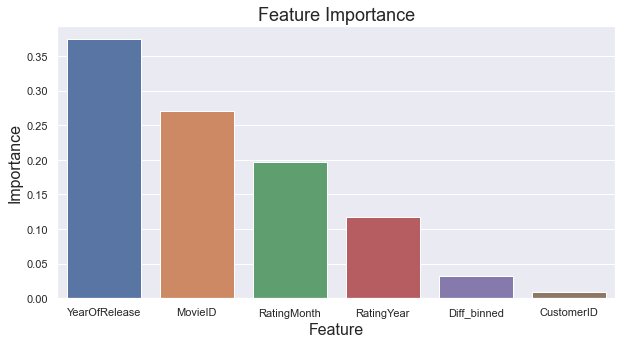

In [19]:
# Plot and rank the features in importance
importance = pd.DataFrame(zip(final_model.stages[-1].featureImportances.toArray(), 
                              input_cols),
                         columns=["Importance", "Feature"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Feature",
            y="Importance", 
            data=importance,
            order=importance.sort_values("Importance", 
                                         ascending=False)["Feature"])

plt.xlabel("Feature", size=16)
plt.ylabel("Importance", size=16)
plt.title("Feature Importance", size=18);

<br>

<a name="conclusions"></a>

## [Conclusions](#top)

We've trained a few models on the 100 million ratings dataset obtained from the Netflix challenge back in 2009 using nothing but a laptop. Although the model performance isn't as good as what was attained by the winning teams (they [reportedly](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429) spent 2,000 hours during the first year of the competition), we've been successful in training a fairly large dataset locally. This in less time than what it takes to return from an outdoor exercise session.

A final score of 1.149 RMSE (interpreted as 1.149 points off, on average) was achieved while identifying release year, movie ID and rating month to be the most important features when predicting a movie's rating. This is not to say that other features wouldn't be important in making this prediction, but rather that out of the features available in the dataset, these are the most important. 

We only briefly covered feature engineering - the process of creating new features out of current or external data - but this is often an incredibly important aspect in machine learning with significant predictive benefits. Examples of engineered features can be the average rating per movie or year, or count/average of ratings per day and movie, number of days since a customer's first rating, and many more. 